1. Imports and Setup

In [ ]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_scheduler,
    DataCollatorWithPadding
)
from tqdm import tqdm

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


2. Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/Assignment/fake_job_postings.csv"
df = pd.read_csv(file_path)

Mounted at /content/drive


3. Build a stronger text field

In [ ]:
text_cols = [c for c in [
    'title', 'company_profile', 'description', 'requirements', 'benefits'
] if c in df.columns]

assert len(text_cols) > 0, "No text columns found. Expect at least 'description'."

def join_text(row):
    parts = []
    for c in text_cols:
        val = str(row.get(c, ""))
        if val and val.lower() != "nan":
            parts.append(val)
    return " ".join(parts)

df['__text__'] = df.apply(join_text, axis=1).astype(str)

In [ ]:
# Clean minimal noise (optional but safe)
def basic_clean(s: str) -> str:
    s = re.sub(r'\s+', ' ', s)
    s = s.strip()
    return s

df['__text__'] = df['__text__'].apply(basic_clean)

In [ ]:
# Labels
if 'fraudulent' not in df.columns:
    raise ValueError("CSV must contain a 'fraudulent' column with 0/1 labels.")
labels = df['fraudulent'].astype(int).tolist()
texts  = df['__text__'].astype(str).tolist()

In [ ]:
# Sanity check
assert len(texts) == len(labels), f"Texts ({len(texts)}) and labels ({len(labels)}) must match."

4. Train-test split

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print(f"Train size: {len(train_texts)} | Val size: {len(val_texts)}")
print("Val class counts:", {k:int(v) for k,v in pd.Series(val_labels).value_counts().sort_index().items()})

Train size: 14304 | Val size: 3576
Val class counts: {0: 3403, 1: 173}


5. Tokenizer and Dataset

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
MAX_LEN = 128

class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JobDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset   = JobDataset(val_texts,   val_labels,   tokenizer, MAX_LEN)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Dynamic padding => faster than padding everything to MAX_LEN
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

6. DataLoaders

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2  # 2-4 is usually stable on Colab
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collator)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collator)

7. Model, Optimizer and Scheduler

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

LR = 5e-5
WEIGHT_DECAY = 0.01
EPOCHS = 4
ACCUM_STEPS = 2
TOTAL_STEPS = math.ceil(len(train_loader) / ACCUM_STEPS) * EPOCHS
WARMUP_STEPS = int(0.1 * TOTAL_STEPS)  # 10% warmup

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8. Focal Loss

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction="mean"):
        super().__init__()
        self.alpha = alpha  # tensor of size [num_classes] or None
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        # CE per-sample
        ce = torch.nn.functional.cross_entropy(logits, targets, reduction="none", weight=self.alpha)
        pt = torch.exp(-ce)        # pt = softmax prob for the target class
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

In [ ]:
# class-balanced weights: alpha_c = N / (K * n_c)
train_counts = pd.Series(train_labels).value_counts().sort_index()  # index 0,1
num_classes = len(train_counts)
N = len(train_labels)
alpha = torch.tensor([N / (num_classes * train_counts.get(i, 1)) for i in range(num_classes)],
                     dtype=torch.float, device=device)

loss_fn = FocalLoss(alpha=alpha, gamma=2.5)  # try 2.0–3.0 if you want to tinker
scaler = GradScaler()

/tmp/ipython-input-3071058314.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


9. Utilities

In [ ]:
def evaluate(model, loader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            for k in ["input_ids", "attention_mask", "labels"]:
                batch[k] = batch[k].to(device)
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = loss_fn(outputs.logits, batch["labels"])
            total_loss += loss.item()
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].detach().cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(batch["labels"].detach().cpu().numpy())
    avg_loss = total_loss / len(loader)

    # Apply threshold to get predictions
    preds = (np.array(all_probs) > threshold).astype(int)
    acc  = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, average="macro", zero_division=0)
    rec  = recall_score(all_labels, preds, average="macro", zero_division=0)
    f1   = f1_score(all_labels, preds, average="macro", zero_division=0)

    report = classification_report(all_labels, preds, digits=4, zero_division=0)
    # Grab minority-class (1) F1 for early stopping criterion
    f1_fraud = f1_score(all_labels, preds, pos_label=1, average="binary", zero_division=0)
    return {
        "loss": avg_loss, "acc": acc, "prec": prec, "rec": rec, "f1_macro": f1,
        "report": report, "probs": np.array(all_probs), "labels": np.array(all_labels),
        "f1_fraud": f1_fraud
    }

def best_threshold_for_f1(labels, probs):
    # Search thresholds between 0.2 and 0.8 to avoid extremes; step=0.01
    ts = np.linspace(0.2, 0.8, 61)
    best_t, best_f1 = 0.5, -1.0
    for t in ts:
        preds = (probs > t).astype(int)
        f1 = f1_score(labels, preds, pos_label=1, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

Add Class Weight

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# compute class weights from your training labels (train_labels must be your full y_train array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

print("Class Weights:", class_weights)


Class Weights: tensor([ 0.5255, 10.3203], device='cuda:0')


10. Training Loop and Validation

In [ ]:
BEST_PATH = "/content/best_distilbert.pt"
best_f1_fraud = -1.0
epochs_no_improve = 0
PATIENCE = 2  # stop if no improvement in minority F1 for 2 consecutive epochs
CLIP_NORM = 1.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in pbar:
        for k in ["input_ids", "attention_mask", "labels"]:
            batch[k] = batch[k].to(device)

        with autocast():
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = loss_fn(outputs.logits, batch["labels"]) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % ACCUM_STEPS == 0:
            # Grad clipping for stability
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        running_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{running_loss/(step+1):.4f}")

    train_loss = running_loss / len(train_loader)

    # ===== Validation with dynamic threshold =====
    with torch.no_grad():
        raw_eval = evaluate(model, val_loader, threshold=0.5)
        # Find best threshold for minority F1 on this epoch
        t_best, f1_best = best_threshold_for_f1(raw_eval["labels"], raw_eval["probs"])
        tuned_eval = evaluate(model, val_loader, threshold=t_best)

    print("\n" + "="*70)
    print(f"Epoch {epoch} finished.")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss (t=0.50): {raw_eval['loss']:.4f} | F1 Fraud (0.50): {raw_eval['f1_fraud']:.4f}")
    print(f"Best threshold found: {t_best:.2f} | F1 Fraud (best t): {tuned_eval['f1_fraud']:.4f}")
    print(f"Val Acc: {tuned_eval['acc']:.4f} | Macro Precision: {tuned_eval['prec']:.4f} | Macro Recall: {tuned_eval['rec']:.4f} | Macro F1: {tuned_eval['f1_macro']:.4f}")
    print("Classification report @ best threshold:\n")
    print(tuned_eval["report"])
    print("="*70 + "\n")

    # Early stopping on Fraudulent F1
    if tuned_eval["f1_fraud"] > best_f1_fraud:
        best_f1_fraud = tuned_eval["f1_fraud"]
        epochs_no_improve = 0
        torch.save({"model_state": model.state_dict(),
                    "threshold": t_best,
                    "tokenizer": tokenizer.name_or_path}, BEST_PATH)
        print(f"✅ New best model saved (Fraud F1={best_f1_fraud:.4f}, t={t_best:.2f}) -> {BEST_PATH}\n")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Fraud F1 for {epochs_no_improve} epoch(s).\n")
        if epochs_no_improve >= PATIENCE:
            print("⏹ Early stopping triggered.")
            break

print(f"Best Fraudulent F1 achieved: {best_f1_fraud:.4f}")

Epoch 1/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/4: 100%|██████████| 447/447 [00:46<00:00,  9.68it/s, loss=0.4151]



Epoch 1 finished.
Train Loss: 0.4151
Val Loss (t=0.50): 0.2231 | F1 Fraud (0.50): 0.7978
Best threshold found: 0.76 | F1 Fraud (best t): 0.8103
Val Acc: 0.9815 | Macro Precision: 0.8982 | Macro Recall: 0.9025 | Macro F1: 0.9003
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9906    0.9900    0.9903      3403
           1     0.8057    0.8150    0.8103       173

    accuracy                         0.9815      3576
   macro avg     0.8982    0.9025    0.9003      3576
weighted avg     0.9816    0.9815    0.9816      3576


✅ New best model saved (Fraud F1=0.8103, t=0.76) -> /content/best_distilbert.pt



Epoch 2/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/4: 100%|██████████| 447/447 [00:45<00:00,  9.91it/s, loss=0.2007]



Epoch 2 finished.
Train Loss: 0.2007
Val Loss (t=0.50): 0.1729 | F1 Fraud (0.50): 0.8389
Best threshold found: 0.79 | F1 Fraud (best t): 0.8795
Val Acc: 0.9888 | Macro Precision: 0.9552 | Macro Recall: 0.9201 | Macro F1: 0.9368
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9921    0.9962    0.9941      3403
           1     0.9182    0.8439    0.8795       173

    accuracy                         0.9888      3576
   macro avg     0.9552    0.9201    0.9368      3576
weighted avg     0.9885    0.9888    0.9886      3576


✅ New best model saved (Fraud F1=0.8795, t=0.79) -> /content/best_distilbert.pt



Epoch 3/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/4: 100%|██████████| 447/447 [00:44<00:00,  9.96it/s, loss=0.0852]



Epoch 3 finished.
Train Loss: 0.0852
Val Loss (t=0.50): 0.2400 | F1 Fraud (0.50): 0.8922
Best threshold found: 0.42 | F1 Fraud (best t): 0.8961
Val Acc: 0.9902 | Macro Precision: 0.9571 | Macro Recall: 0.9345 | Macro F1: 0.9455
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9936    0.9962    0.9949      3403
           1     0.9207    0.8728    0.8961       173

    accuracy                         0.9902      3576
   macro avg     0.9571    0.9345    0.9455      3576
weighted avg     0.9900    0.9902    0.9901      3576


✅ New best model saved (Fraud F1=0.8961, t=0.42) -> /content/best_distilbert.pt



Epoch 4/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/4: 100%|██████████| 447/447 [00:46<00:00,  9.65it/s, loss=0.0277]



Epoch 4 finished.
Train Loss: 0.0277
Val Loss (t=0.50): 0.2648 | F1 Fraud (0.50): 0.8896
Best threshold found: 0.66 | F1 Fraud (best t): 0.8970
Val Acc: 0.9905 | Macro Precision: 0.9677 | Macro Recall: 0.9264 | Macro F1: 0.9460
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9927    0.9974    0.9950      3403
           1     0.9427    0.8555    0.8970       173

    accuracy                         0.9905      3576
   macro avg     0.9677    0.9264    0.9460      3576
weighted avg     0.9903    0.9905    0.9903      3576


✅ New best model saved (Fraud F1=0.8970, t=0.66) -> /content/best_distilbert.pt

Best Fraudulent F1 achieved: 0.8970


In [ ]:
import numpy as np

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in val_loader:  # or test_loader depending on which you evaluate
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


11. Confusion Matrix

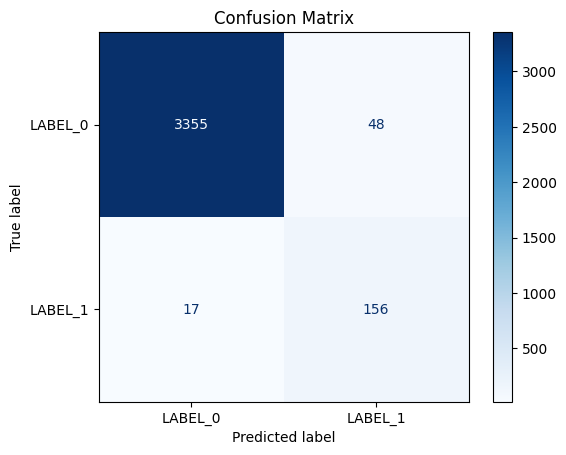

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label.values())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


12. ROC Curve + AUC

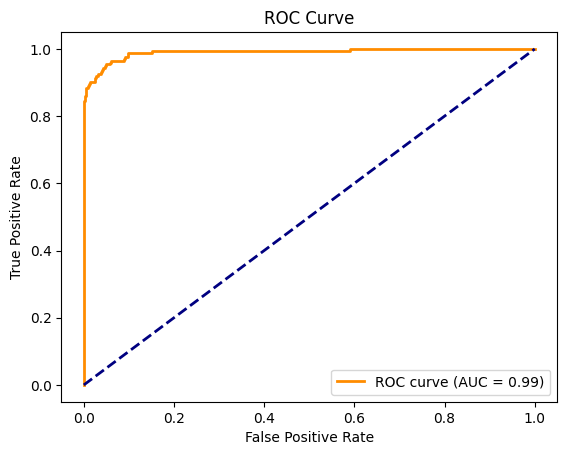

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

y_probs = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)[:,1].cpu().numpy()  # probability for positive class

        y_probs.extend(probs)
        y_true.extend(labels)

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [30]:
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

In [31]:
!pip install transformers torch gradio -q

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr

# Load your trained model (make sure you saved it in ./model)
MODEL_DIR = "./model"   # or change to your path
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()

labels = ["Legit", "Fraud"]   # adjust if your order is different

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=256, return_tensors="pt")
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1).squeeze().tolist()
    pred = labels[int(torch.tensor(probs).argmax())]
    return pred, {labels[i]: float(probs[i]) for i in range(len(labels))}

# Simple Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs="text",
    outputs=["label", "json"],
    title="Fake Job Detector",
    description="Paste a job posting to check if it's Legit or Fraud"
)

demo.launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cdc